In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests

In [3]:
df_data= pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/master/trends/data-by-day.csv')

In [5]:
df_dose = pd.read_csv("https://raw.githubusercontent.com/nychealth/covid-vaccine-data/main/doses/doses-by-day.csv")
df_dose.shape

(373, 11)

In [6]:
df_data.shape

(660, 67)

In [7]:
df_ = df_data[["CASE_COUNT", "HOSPITALIZED_COUNT", "DEATH_COUNT" ]][df_dose.shape[0]:]

In [10]:
df = df_.reset_index(drop=True)
df.shape

(287, 3)

In [11]:
df

,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,3399,295,68
1,3340,282,71
2,3204,282,62
3,3106,294,56
4,3202,293,73
...,...,...,...
282,12128,126,8
283,11492,163,12
284,10490,22,14
285,7113,0,10


In [18]:
df_dose_cumulative = df_dose[["ADMIN_DOSE2_CUMULATIVE"]][-df.shape[0]:]
df_dose_cumulative = df_dose_cumulative.reset_index(drop=True)

In [19]:
df_dose_cumulative

,ADMIN_DOSE2_CUMULATIVE
0,904145
1,925542
2,955422
3,981857
4,997695
...,...
282,5774897
283,5780257
284,5783082
285,5787979


In [20]:
df_final = pd.concat([df, df_dose_cumulative.reindex(df.index)], axis=1)

In [24]:
df_final = df_final[:-3]

In [25]:
df_final

,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,ADMIN_DOSE2_CUMULATIVE
0,3399,295,68,904145
1,3340,282,71,925542
2,3204,282,62,955422
3,3106,294,56,981857
4,3202,293,73,997695
...,...,...,...,...
277,3005,125,16,5744999
278,2098,92,7,5752187
279,2669,96,17,5758700
280,7296,135,18,5764467


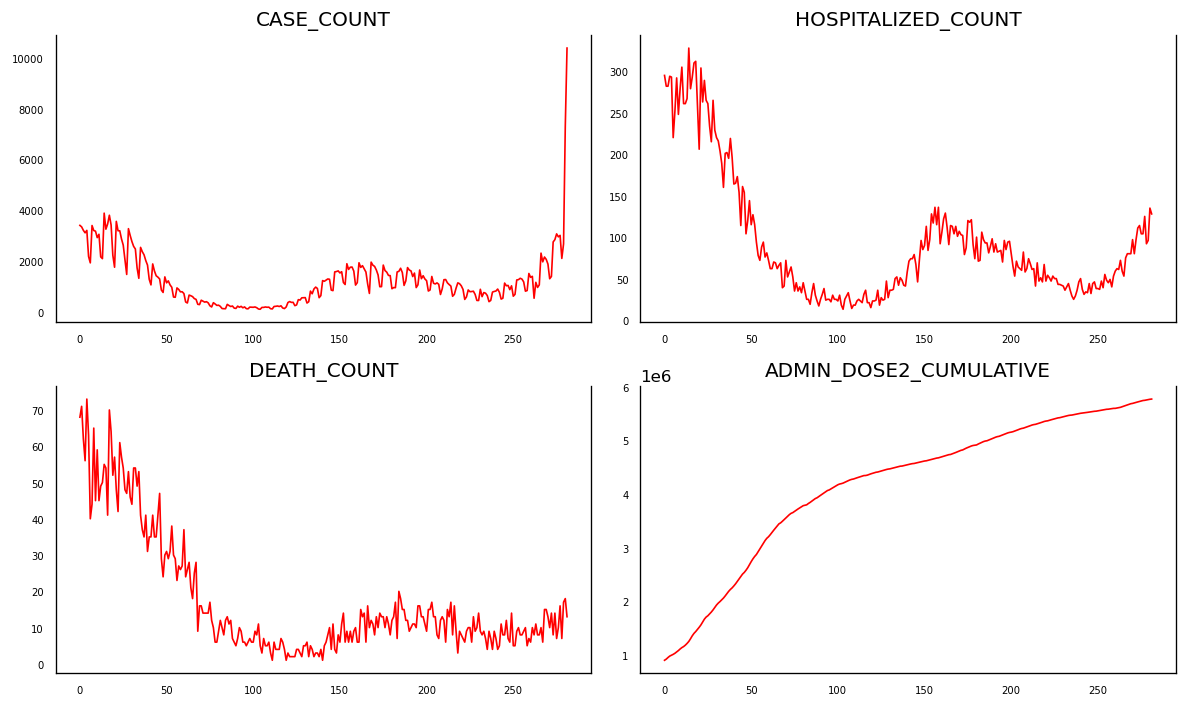

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_final[df_final.columns[i]]
    ax.plot(data, color='red', linewidth=1)

    ax.set_title(df_final.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [28]:
maxlag = 4
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False): 
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [29]:
grangers_causation_matrix(df_final, variables = df_final.columns)

,CASE_COUNT_x,HOSPITALIZED_COUNT_x,DEATH_COUNT_x,ADMIN_DOSE2_CUMULATIVE_x
CASE_COUNT_y,1.0000,0.0000,0.010,0.0
HOSPITALIZED_COUNT_y,0.0357,1.0000,0.000,0.0
DEATH_COUNT_y,0.0000,0.0000,1.000,0.0
ADMIN_DOSE2_CUMULATIVE_y,0.0001,0.0331,0.026,1.0


In [30]:
test_size = 7

In [31]:
df_train = df_final[:-test_size]
df_test =df_final[-test_size:]
df_differenced = df_train.diff().dropna()

In [32]:
df_differenced = df_differenced.diff().dropna()

In [33]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  39.36256502187941
BIC :  39.62769752675412
FPE :  1.2443770068838938e+17
HQIC:  39.46900651373888 

Lag Order = 2
AIC :  38.072448446158404
BIC :  38.55095869542655
FPE :  3.425285065520883e+16
HQIC:  38.26457550102094 

Lag Order = 3
AIC :  37.037639495484996
BIC :  37.73066890981061
FPE :  1.217227916006641e+16
HQIC:  37.31592992348268 

Lag Order = 4
AIC :  36.675153286068635
BIC :  37.583853560466125
FPE :  8474414592192755.0
HQIC:  37.04008919195139 

Lag Order = 5
AIC :  36.328653441352905
BIC :  37.45418667405034
FPE :  5996432929814100.0
HQIC:  36.78072127720967 

Lag Order = 6
AIC :  35.24510291921234
BIC :  36.58864174258322
FPE :  2030997716624768.0
HQIC:  35.784793538007314 

Lag Order = 7
AIC :  34.8468784764728
BIC :  36.40960619007685
FPE :  1365584430548529.2
HQIC:  35.47468718641192 

Lag Order = 8
AIC :  34.826680989152266
BIC :  36.609791694926535
FPE :  1340580378534673.5
HQIC:  35.54310760889525 

Lag Order = 9
AIC :  34.595115720258065
BIC :  

C:\Users\13301\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [34]:
x = model.select_order(maxlags=40)
x.summary()

,AIC,BIC,FPE,HQIC
0,38.90,38.96,7.817e+16,38.92
1,37.72,38.02,2.416e+16,37.84
2,36.45,36.99,6.778e+15,36.67
3,35.89,36.66,3.853e+15,36.20
4,35.62,36.62,2.944e+15,36.02
5,35.28,36.52,2.099e+15,35.78
6,34.40,35.88,8.765e+14,35.00
7,34.13,35.85*,6.685e+14,34.82*
8,34.10,36.06,6.530e+14,34.89
9,34.01,36.21,5.978e+14,34.90


In [35]:
model_fitted = model.fit(8)

In [36]:
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, Dec, 2021
Time:                     14:30:56
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    36.6098
Nobs:                     265.000    HQIC:                   35.5431
Log likelihood:          -5986.61    FPE:                1.34058e+15
AIC:                      34.8267    Det(Omega_mle):     8.38323e+14
--------------------------------------------------------------------
Results for equation CASE_COUNT
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             4.017177        11.189595            0.359           0.720
L1.CASE_COUNT                    -1.203671         0.067281          -17.890           0.000
L1.HOSP

In [37]:
lag_order = model_fitted.k_ar
print(lag_order)  

8


In [38]:
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[-1.594e+03, -1.700e+01, -6.000e+00,  1.210e+02],
       [ 5.340e+02, -5.000e+00,  1.300e+01,  1.743e+03],
       [-2.820e+02,  0.000e+00, -9.000e+00, -1.599e+03],
       [-9.500e+01,  1.700e+01, -2.000e+00, -5.345e+03],
       [-3.890e+02, -3.400e+01, -1.000e+00,  4.082e+03],
       [ 6.650e+02,  3.400e+01,  7.000e+00, -7.080e+02],
       [ 1.270e+03, -3.000e+00, -1.000e+01, -5.330e+02],
       [-1.267e+03, -1.100e+01,  1.200e+01, -1.100e+01]])

In [39]:
fc = model_fitted.forecast(y=forecast_input, steps=test_size)
df_forecast = pd.DataFrame(fc, index=df_final.index[-test_size:], columns=df_final.columns + '_2d')
df_forecast

,CASE_COUNT_2d,HOSPITALIZED_COUNT_2d,DEATH_COUNT_2d,ADMIN_DOSE2_CUMULATIVE_2d
275,-155.944736,4.813082,-4.775833,535.571103
276,-81.829630,-5.048817,1.966358,-2480.349887
277,-11.162330,-3.764450,-3.704086,-4451.954059
278,-260.335178,-3.189492,-1.014355,3033.432147
279,521.615002,9.000950,4.160735,1893.836726
280,1071.028400,24.608696,-2.642511,-40.144221
281,-1011.636887,-29.393363,-2.834547,914.460663


In [40]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [41]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        

In [42]:
df_results

,CASE_COUNT_2d,HOSPITALIZED_COUNT_2d,DEATH_COUNT_2d,ADMIN_DOSE2_CUMULATIVE_2d,CASE_COUNT_1d,CASE_COUNT_forecast,HOSPITALIZED_COUNT_1d,HOSPITALIZED_COUNT_forecast,DEATH_COUNT_1d,DEATH_COUNT_forecast,ADMIN_DOSE2_CUMULATIVE_1d,ADMIN_DOSE2_CUMULATIVE_forecast
275,-155.944736,4.813082,-4.775833,535.571103,-63.944736,2774.055264,7.813082,121.813082,1.224167,15.224167,9101.571103,5.732705e+06
276,-81.829630,-5.048817,1.966358,-2480.349887,-145.774365,2628.280899,2.764265,124.577347,3.190525,18.414692,6621.221216,5.739326e+06
277,-11.162330,-3.764450,-3.704086,-4451.954059,-156.936696,2471.344203,-1.000185,123.577162,-0.513561,17.901131,2169.267157,5.741495e+06
278,-260.335178,-3.189492,-1.014355,3033.432147,-417.271874,2054.072329,-4.189677,119.387485,-1.527917,16.373215,5202.699303,5.746698e+06
279,521.615002,9.000950,4.160735,1893.836726,104.343128,2158.415457,4.811274,124.198759,2.632818,19.006033,7096.536029,5.753794e+06
280,1071.028400,24.608696,-2.642511,-40.144221,1175.371528,3333.786986,29.419969,153.618728,-0.009693,18.996340,7056.391808,5.760851e+06
281,-1011.636887,-29.393363,-2.834547,914.460663,163.734641,3497.521627,0.026607,153.645335,-2.844240,16.152100,7970.852471,5.768822e+06


In [43]:
df_results.loc[:, ['CASE_COUNT_forecast', 'HOSPITALIZED_COUNT_forecast', 'DEATH_COUNT_forecast', 'ADMIN_DOSE2_CUMULATIVE_forecast']]

,CASE_COUNT_forecast,HOSPITALIZED_COUNT_forecast,DEATH_COUNT_forecast,ADMIN_DOSE2_CUMULATIVE_forecast
275,2774.055264,121.813082,15.224167,5.732705e+06
276,2628.280899,124.577347,18.414692,5.739326e+06
277,2471.344203,123.577162,17.901131,5.741495e+06
278,2054.072329,119.387485,16.373215,5.746698e+06
279,2158.415457,124.198759,19.006033,5.753794e+06
280,3333.786986,153.618728,18.996340,5.760851e+06
281,3497.521627,153.645335,16.152100,5.768822e+06


In [47]:
df_results["CASE_COUNT_forecast"]

275    2774.055264
276    2628.280899
277    2471.344203
278    2054.072329
279    2158.415457
280    3333.786986
281    3497.521627
Name: CASE_COUNT_forecast, dtype: float64

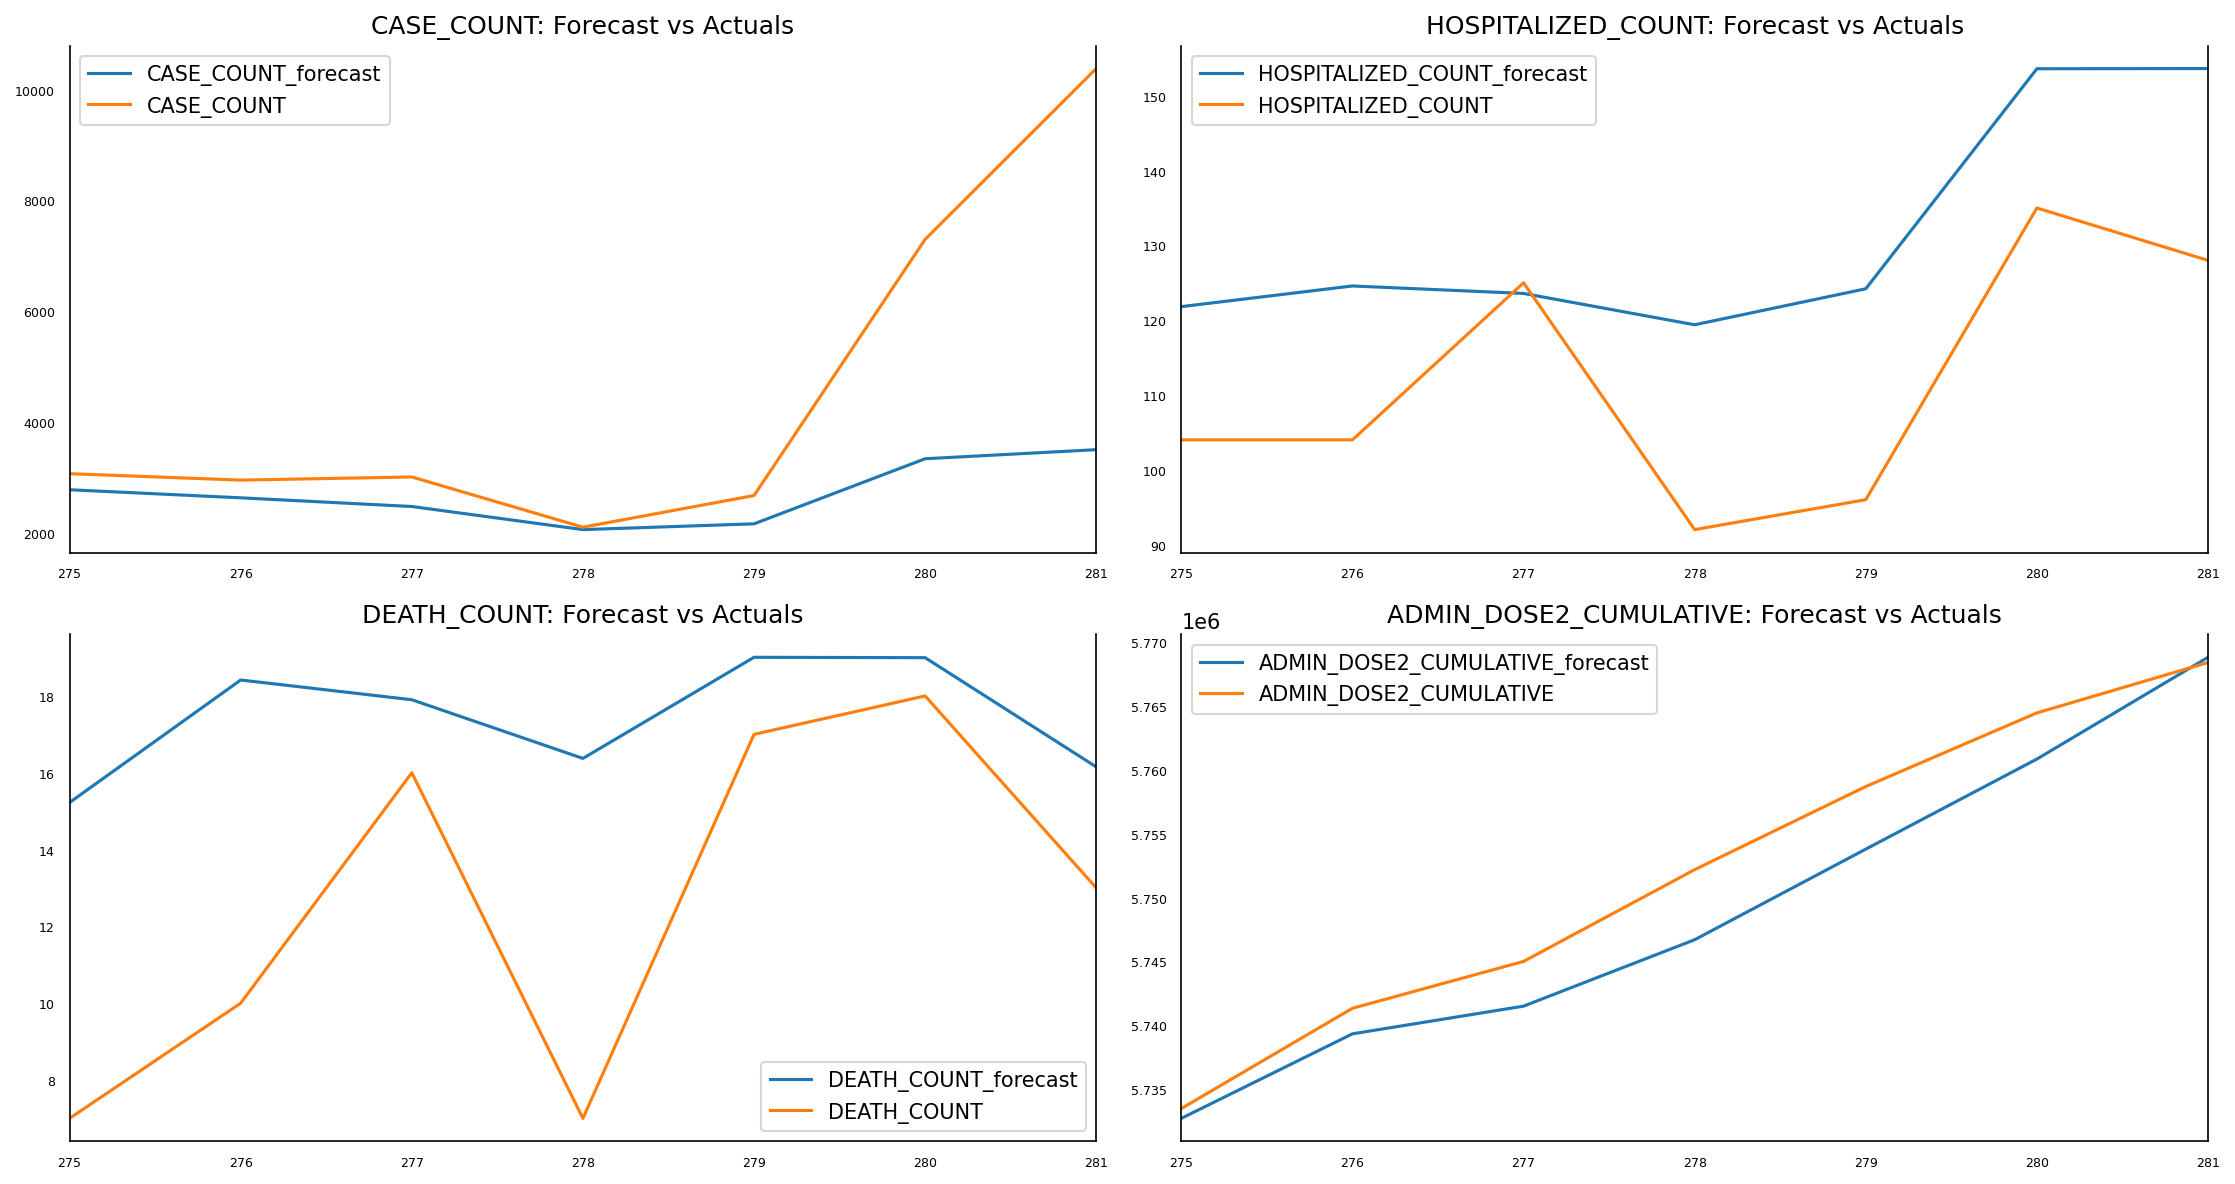

In [46]:
fig, axes = plt.subplots(nrows=int(len(df_final.columns)/2), ncols=2, dpi=150, figsize=(15,8))
for i, (col,ax) in enumerate(zip(df_final.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-test_size:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [27]:
df_differenced_all = df_final.diff().dropna()
df_differenced_all = df_differenced.diff().dropna()

In [28]:
forecast_input_all = df_differenced_all.values[-lag_order:]
forecast_input

array([[ 1.152e+03,  2.500e+01,  2.000e+00,  5.138e+03],
       [-1.605e+03, -1.800e+01, -6.000e+00,  1.400e+01],
       [ 5.440e+02,  1.000e+00,  1.300e+01, -7.500e+01],
       [-2.840e+02, -1.600e+01, -1.100e+01,  1.230e+02],
       [-1.010e+02,  3.300e+01,  0.000e+00,  1.741e+03],
       [-3.870e+02, -2.800e+01,  0.000e+00, -1.610e+03],
       [ 6.660e+02,  1.900e+01,  5.000e+00, -5.322e+03],
       [ 1.244e+03,  3.000e+00, -7.000e+00,  4.078e+03]])

In [48]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [49]:
def adjust(val, length= 6): return str(val).ljust(length)

In [50]:
print('\nForecast Accuracy of: casecount')
accuracy_prod = forecast_accuracy(df_results['CASE_COUNT_forecast'].values, df_test['CASE_COUNT'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: casecount
mape   :  0.257
me     :  -1791.789
mae    :  1791.789
mpe    :  -0.257
rmse   :  3019.0193
corr   :  0.9107
minmax :  0.257
